In [0]:
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dir_path1= '/content/drive/My Drive/Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/garbage-queried-images'
dir_path2= '/content/drive/My Drive/Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/non-garbage-queried-images'

In [0]:
dir_path= '/content/drive/My Drive/Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage'
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))
len(img_list)

2242

In [0]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical', #class_mode='binary'
                                          shuffle=True,
                                          seed=42,
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical', #class_mode='binary'
                                        shuffle=True,
                                        seed=42,
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2202 images belonging to 2 classes.
Found 244 images belonging to 2 classes.
{'garbage-queried-images': 0, 'non-garbage-queried-images': 1}
{0: 'garbage-queried-images', 1: 'non-garbage-queried-images'}


In [0]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 2))

In [0]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)

{'garbage-queried-images': 0, 'non-garbage-queried-images': 1}


In [0]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5)) # No accuracy

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5))

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
#model.add(SpatialDropout2D(0.5))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43808)            

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']) # RMS PROP - No accuracy

In [0]:
history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=2276//32,
                              validation_data=test_generator,
                              validation_steps=251//32,
                              workers = 4,
                              callbacks=callbacks_list) 

Epoch 1/1
71/71 [==============================] - 447s 6s/step - loss: 0.6391 - acc: 0.6312 - val_loss: 0.6463 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to trained_model.h5


Maximum Probability:  0.51052463
Classified: non-garbage-queried-images


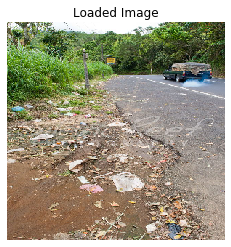

In [0]:
from keras.preprocessing import image
img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/garbage-queried-images/f62feb16-6798-11e5-8dd0-40f2e96c8ad8.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

In [0]:
from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/garbage-queried-images/f2b7e2da-679e-11e5-b0e3-40f2e96c8ad8.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

In [0]:
from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/garbage-queried-images/ec63509c-679c-11e5-aa4a-40f2e96c8ad8.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

In [0]:
from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/test.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

In [0]:
from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/non-garbage-queried-images/ff928086-943b-11e5-b41b-40f2e96c8ad8.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

NameError: ignored

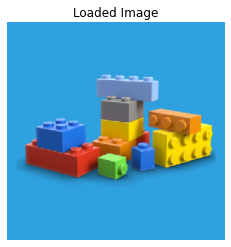

In [0]:


from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/SupportRecplacementPromo.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

Maximum Probability:  0.9999478
Classified: non-garbage-queried-images


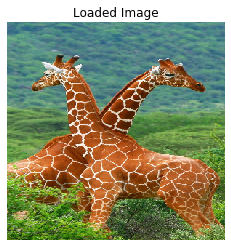

In [0]:


from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/a1a2539232a7a263a618ae31f301df65.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


Maximum Probability:  0.8936131
Classified: garbage-queried-images


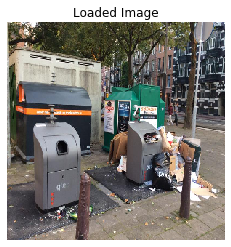

In [0]:
from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/mdc_photo_mdc_ffb4a0_cdv_photo_001_1506270040778.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

Maximum Probability:  0.79741454
Classified: non-garbage-queried-images


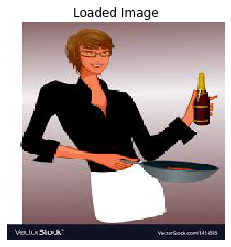

In [0]:

from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/imagess.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

Maximum Probability:  0.99984574
Classified: non-garbage-queried-images


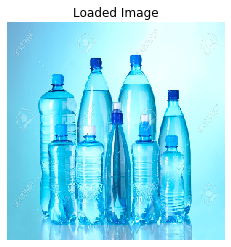

In [0]:
from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/10487570-group-plastic-bottles-of-water-on-blue-background.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


AttributeError: ignored

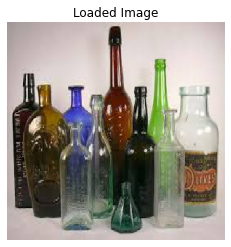

In [0]:
from keras.preprocessing import image

import numpy as np

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/download.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0
with open('/content/drive/My Drive/Waste Management/my_model.h5', 'w') as f:
   model=f

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())


p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


Maximum Probability:  0.9486517
Classified: garbage-queried-images


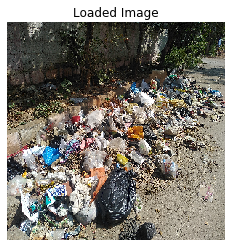

In [0]:
from keras.preprocessing import image

img_path = '/content/drive/My Drive//Waste Management/Trying_trash/spotgarbage-GINI/spotgarbage/IMG_20191117_101439.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


In [0]:
model.save('my_model.h5')

In [0]:
from google.colab import files
files.download("my_model.h5")